In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models

import os
import torch
import librosa

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../")
from dataset.datasets import AudioDataset

### package path

In [3]:
# path to urban sound 8k
data_root = "../UrbanSound8K/"
# path to label
label_path = "../UrbanSound8K/metadata/UrbanSound8K.csv"  

### learning rate

In [4]:
def lr_schedule(epoch, init_lr):
    if epoch <20:
        return init_lr
    elif epoch>=20 and epoch<40:
        return init_lr/10
    elif epoch>=40 and epoch <80:
        return init_lr/100
    else:
        return init_lr/1000

### model construction

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self,inchannel,outchannel,stride,shortcut=None):
        super(ResidualBlock,self).__init__()
        self.basic = nn.Sequential(
            nn.Conv2d(inchannel,outchannel,3,stride,1,bias=False),#要采样的话在这里改变stride
            nn.BatchNorm2d(outchannel),#批处理正则化
            nn.ReLU(inplace=True),#激活
            nn.Conv2d(outchannel,outchannel,3,1,1,bias=False),#采样之后注意保持feature map的大小不变
            nn.BatchNorm2d(outchannel),
        )
        self.shortcut = shortcut
    
    def forward(self,x):
        out = self.basic(x)
        residual = x if self.shortcut is None else self.shortcut(x)#计算残差
        out += residual
        return nn.ReLU(inplace=True)(out)#注意激活
#ResNet类
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet,self).__init__()
        self.pre = nn.Sequential(
            nn.Conv2d(3,64,7,2,3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3,2,1),
        )#开始的部分
        self.body = self.makelayers([3,4,6,3])#具有重复模块的部分
        self.classifier = nn.Linear(512,10)#末尾的部分
        
    def makelayers(self,blocklist):#注意传入列表而不是解列表
        self.layers = []
        for index,blocknum in enumerate(blocklist):
            if index != 0:
                shortcut = nn.Sequential(
                    nn.Conv2d(64*2**(index-1),64*2**index,1,2,bias=False),
                    nn.BatchNorm2d(64*2**index)
                )#使得输入输出通道数调整为一致
                self.layers.append(ResidualBlock(64*2**(index-1),64*2**index,2,shortcut))#每次变化通道数时进行下采样
            for i in range(0 if index==0 else 1,blocknum):
                self.layers.append(ResidualBlock(64*2**index,64*2**index,1))
        return nn.Sequential(*self.layers)
    
    def forward(self,x):
        x = self.pre(x)
        x = self.body(x)
        x = nn.AvgPool2d(7)(x)#kernel_size为7是因为经过多次下采样之后feature map的大小为7*7，即224->112->56->28->14->7
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

In [6]:
net = ResNet()
print(net)

ResNet(
  (pre): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (0): ResidualBlock(
      (basic): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (basic): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.

In [7]:
print(models.resnet34(num_classes=10))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### training fuction

In [14]:
def train(MAX_EPOCH = 100):

#     eval_interval = 5
    
    # initialize dataset (feature can be "mfcc", "spec", "mel_raw")
    audio_dataset = AudioDataset(5, DataRoot=data_root, LabelPath=label_path, feature="mfcc", mode="train")

    # define resnet model
    cnn_model = models.resnet18(num_classes=10)
    #cnn_model =ResNet()
    # to gpu
    cnn_model = cnn_model.cuda()
    #print(cnn_model)
    # initialize dataloader
    data_loader = torch.utils.data.DataLoader(audio_dataset, batch_size=32, shuffle=True, num_workers=1)

    # loss function
    loss_fn = nn.CrossEntropyLoss().cuda()

    # lr
    learning_rate = 1e-3

    # initialize optimizer
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
    
    # initialize logger
    train_acc = []
    test_acc = []
    
    train_loss = []
    test_loss = []
    
    for epoch in range(MAX_EPOCH):
        # iterate through dataset
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_schedule(epoch, learning_rate)
            
        # initialize epoch stat
        correct_num = 0
        total_num = 0
        loss_sum = 0

        for idx, data in enumerate(data_loader):
            #print(idx)
            train_data, labels = data
            
            #train_data = train_data.type(torch.float32)/255
            
            # data to gpu
            train_data = train_data.cuda()
            labels = labels.cuda()

            prob = cnn_model(train_data)   
            loss = loss_fn(prob, labels)

            output = prob.argmax(1)
            
            loss_sum += loss.item()*float(labels.shape[0])
            correct_num += (output==labels).sum().double()
            total_num += float(labels.shape[0])

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
        train_acc.append(correct_num/total_num)
        train_loss.append(loss_sum/total_num)
        
        print("epoch: {} acc: {:.4} avg loss: {:.4f}".format(epoch, correct_num/total_num, loss_sum/total_num))
        
#         if epoch%5 == 4:

        a,b = test(cnn_model)
        test_acc.append(a)
        test_loss.append(b)
    
    
    plt.figure()
    plt.plot(np.arange(MAX_EPOCH), train_acc)
#     plt.plot(np.arange(eval_interval-1, MAX_EPOCH, eval_interval), test_acc)
    plt.plot(np.arange(MAX_EPOCH), test_acc)
    plt.title("accuracy")
    plt.legend(["train","val"])
    
    plt.figure()
    plt.plot(np.arange(MAX_EPOCH), train_loss)
#     plt.plot(np.arange(eval_interval-1, MAX_EPOCH, eval_interval), test_loss)
    plt.plot(np.arange(MAX_EPOCH), test_loss)
    plt.title("loss")
    plt.legend(["train","val"])

### Test function

In [15]:
def test(model, ):
    test_dataset = AudioDataset(5, DataRoot=data_root, LabelPath=label_path, feature="mfcc", mode="test")
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=1)
    
    model.eval()

    loss_fn = nn.CrossEntropyLoss().cuda()
    
    correct_num = 0
    total_num = 0
    loss_sum = 0
    
    for idx, data in enumerate(test_loader):
        test_data, labels = data
        test_data = test_data.cuda()
        labels = labels.cuda()

        test_data = test_data.cuda()

        prob = model(test_data)   
        loss = loss_fn(prob, labels)
        
        output = prob.argmax(1)
        
        correct_num += (output==labels).sum().double()
        loss_sum += loss.item()*float(labels.shape[0])
        total_num += float(labels.shape[0])
        
    model.train()

    print("##Testing## epoch acc: {:.4}".format(correct_num/total_num))
    return correct_num/total_num, loss_sum/total_num

verify mfcc feature success
epoch: 0 acc: 0.2199 avg loss: 2.1515
verify mfcc feature success
##Testing## epoch acc: 0.2201
epoch: 1 acc: 0.2851 avg loss: 1.9610
verify mfcc feature success
##Testing## epoch acc: 0.1763
epoch: 2 acc: 0.3638 avg loss: 1.7972
verify mfcc feature success
##Testing## epoch acc: 0.3387
epoch: 3 acc: 0.4433 avg loss: 1.5925
verify mfcc feature success
##Testing## epoch acc: 0.3782
epoch: 4 acc: 0.5249 avg loss: 1.3813
verify mfcc feature success
##Testing## epoch acc: 0.3985
epoch: 5 acc: 0.6026 avg loss: 1.1548
verify mfcc feature success
##Testing## epoch acc: 0.5214
epoch: 6 acc: 0.6528 avg loss: 1.0095
verify mfcc feature success
##Testing## epoch acc: 0.4786
epoch: 7 acc: 0.6997 avg loss: 0.8901
verify mfcc feature success
##Testing## epoch acc: 0.5256
epoch: 8 acc: 0.7376 avg loss: 0.7779
verify mfcc feature success
##Testing## epoch acc: 0.5737
epoch: 9 acc: 0.7594 avg loss: 0.6997
verify mfcc feature success
##Testing## epoch acc: 0.5556
epoch: 10 ac

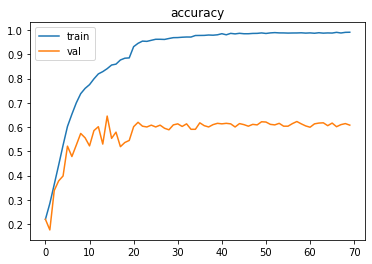

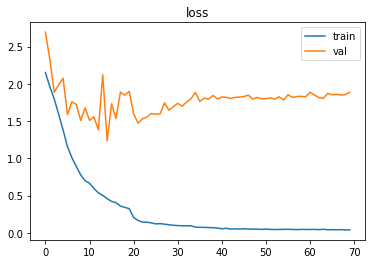

In [16]:
train(70)